# Laboratorio 3.6: Cuaderno del estudiante

## Información general

Este laboratorio es una continuación de los laboratorios guiados del Módulo 3.

En este laboratorio, evaluará el modelo que entrenó en los módulos anteriores. También calculará métricas basadas en los resultados de los datos de prueba.


## Presentación de la situación empresarial

Trabaja para un proveedor de atención médica y desea mejorar la detección de anomalías en los pacientes de ortopedia. 

Se le asignó la tarea de resolver este problema con el uso de machine learning (ML). Tiene acceso a un conjunto de datos que contiene seis funciones biomecánicas y un objetivo de *normal* o *anormal*. Puede usar este conjunto de datos para entrenar un modelo de ML para predecir si un paciente tendrá una anomalía.


## Acerca de este conjunto de datos

Este conjunto de datos biomédicos fue creado por el Dr. Henrique da Mota durante un periodo de residencia médica en el Group of Applied Research in Orthopaedics (GARO) del Centre Médico-Chirurgical de Réadaptation des Massues, Lyon, Francia. Los datos se organizaron en dos tareas de clasificación diferentes pero que se relacionan. 

La primera tarea consiste en clasificar pacientes como pertenecientes a una de tres categorías: 

- *Normal* (100 pacientes)
- *Hernia de disco* (60 pacientes)
- *Espondilolistesis* (150 pacientes)

Para la segunda tarea, las categorías *hernia de disco* y *espondilolistesis* se fusionaron en una sola categoría que se denomina *anormal*. Por ende, la segunda tarea consiste en clasificar a los pacientes como pertenecientes a una de dos categorías: *normal* (100 pacientes) o *anormal* (210 pacientes).


## Información de atributos

Cada paciente está representado en el conjunto de datos por seis atributos biomecánicos que se derivan de la forma y la orientación de la pelvis y la columna lumbar (en este orden): 

- Pelvic incidence (Incidencia pélvica)
- Pelvic tilt (Inclinación pélvica)
- Lumbar lordosis angle (Ángulo de lordosis lumbar)
- Sacral slope (Pendiente sacra)
- Pelvic radius (Radio pélvico)
- Grade of spondylolisthesis (Grado de espondilolistesis)

Se usa la siguiente convención para las etiquetas de clase: 
- DH (hernia de disco)
- SL (espondilolistesis)
- NO (normal) 
- AB (anormal)

Para obtener más información sobre este conjunto de datos, consulte la [página web del conjunto de datos de la columna vertebral](http://archive.ics.uci.edu/ml/datasets/Vertebral+Column).


## Atribuciones del conjunto de datos

Este conjunto de datos se obtuvo de:
Dua, D. y Graff, C. (2019). Repositorio de Machine Learning de UCI (http://archive.ics.uci.edu/ml). Irvine, CA: Universidad de California, School of Information and Computer Science.


# Configuración del laboratorio

Debido a que esta solución se divide en varios laboratorios en el módulo, debe ejecutar las siguientes celdas para poder cargar los datos y entrenar el modelo que se implementará.

**Nota:** La configuración puede tardar hasta 5 minutos en completarse.

## Importación de los datos y entrenamiento del modelo

Ejecute las siguientes celdas para importar los datos y dejarlos listos para utilizarse. 

**Nota:** Las siguientes celdas representan los pasos clave de los laboratorios anteriores.


In [1]:
bucket='c190240a4907840l13104834t1w145414187560-labbucket-63vrud8r1osf'

In [2]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])

class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

prefix='lab3'

train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

xgb_model.fit(inputs=data_channels, logs=False)

batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-12-11-10-21-58-256



2025-12-11 10:22:00 Starting - Starting the training job....
2025-12-11 10:22:25 Starting - Preparing the instances for training......
2025-12-11 10:23:01 Downloading - Downloading input data.....
2025-12-11 10:23:31 Downloading - Downloading the training image.............
2025-12-11 10:24:42 Training - Training image download completed. Training in progress..
2025-12-11 10:24:52 Uploading - Uploading generated training model...
2025-12-11 10:25:11 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-12-11-10-25-15-751


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2025-12-11-10-25-16-305


.......................................
...

# Paso 4: cálculo de la curva AUC-ROC

La biblioteca scikit-learn tiene funciones que le permiten calcular la *el área bajo la curva de la característica operativa del receptor (AUC-ROC)*.

- La ROC es una curva de probabilidad.
- El AUC le indica qué tan bien el modelo puede distinguir entre clases. 

El AUC se puede calcular. Como verá en el siguiente laboratorio, se puede usar para medir el rendimiento del modelo. 

En este ejemplo, cuanto más alta es el AUC, mejor es el modelo para distinguir entre pacientes anormales y normales.

Dependiendo del valor que establezca para el umbral, el AUC puede cambiar. Puede trazar el AUC con la probabilidad en lugar de con la clase convertida.


In [19]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted) )

Validation AUC 0.8904761904761904


Normalmente, la curva ROC se traza con la TPR en comparación con la FPR, donde la TPR se ubica en el eje y mientras que la FPR está en el eje x.

Scikit-learn tiene la función **roc_curve** para ayudar con la generación de esos valores para trazar.

Figure(640x480)


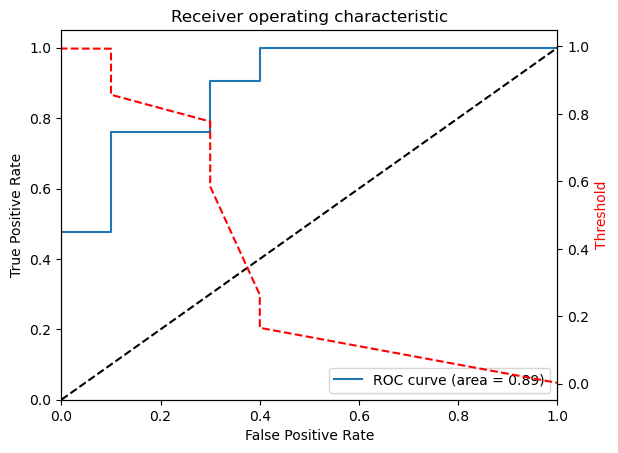

<Figure size 640x480 with 0 Axes>

In [21]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
#ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

print(plt.figure())

**Tarea de desafío:** actualice el código anterior para usar *target_predicted_binary* en lugar de *target_predicted*. ¿Cómo cambia eso el grafo? ¿Cuál es más útil?

# ¡Felicitaciones!

Completó este laboratorio y ahora puede finalizarlo siguiendo las instrucciones en la guía del laboratorio.